# 2D Monte Carlo Lattice Simulation of Polymers


In 1987, Sariban and Binder published a paper entitiled *Critical properties of the Flory–Huggins lattice model of polymer mixtures*. 

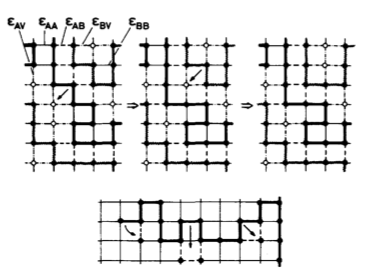

In their model, an energy $\epsilon$ is won if two neighboring sites are occupied by the same polymer type. In the frame work the gibbs free energy of mixing is: 

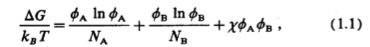



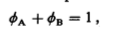

Where $\chi$ is the Flory-Huggins interaction parameter $\phi$ is the number of lattice sites occupied by polymer type A or type B. This work simulates polymers that are allowed to wriggle about on a 3D lattice. Thus, the coordination number, *z*, in the expression for $\chi$ is 6. For the simulations below, given a 2D lattice, the coordination number is 4.

The magic of the Monte Carlo algorythm is calculating the transition probability from one microstate to another. In their work the probability is as follows: 

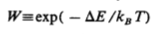

A move is proposed, and it is executed if this probability excceeds a random number in the interval [0,1]. This will allow a system to move in the "wrong" direction from a free energy gradient perspective, but only in proportion to the magnitude of the increase of the Gibbs free energy like term above. This allows systems to "escape" local minima in the potential energy landscape. 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as im
import os
from PIL import Image
import glob
from pylab import arange
from scipy.ndimage import measurements

class System:
    '''this should track all atributes of the system'''
    
    def __init__(
        self,
        grid_size,n_polymers,l_polymer
    ):
        #intitialize the grid as all solvent in the specified 
        #grid size
        self.data = np.zeros((grid_size,grid_size), dtype = int)
        self.polymers = self.add_polymers(n_polymers,l_polymer)
        self.trajectory = []
        self.E = 0
        
    def add_polymers(self, polymer_number, polymer_length):
        polymer_list = []
        for i in range(polymer_number):
            polymer = Polymer(self.data,i+1,polymer_length)
            polymer_list.append(polymer)
            for cell in polymer.polymer_locations:
                self.data[cell[0]][cell[1]] = i+1
        return polymer_list    
            
    def wriggle(self, number_of_wriggles):
        
        for number in range(number_of_wriggles):
            system_data = self.data
            random_poly = random.randint(0,len(self.polymers)-1)
            #polymer.neighbor_list()
            self.polymers[random_poly].make_a_move(system_data)
            self.update_system_data()

    def copy(self, copy_from):
         for i in range(len(copy_from)):
            self.polymers[i]=copy_from[i]
            
    def wiggle_polymers(self, number_of_wriggles):
        self.update_system_data()
        for number in range(number_of_wriggles):
            random_poly = random.randint(0,len(self.polymers)-1)
            self.polymers[random_poly].make_a_move(self.data)
            self.update_system_data()
            self.polymers
    
    def update_system_data(self):
        grid_size = len(self.data[0])
        #self.trajectory.append(self.data)
        self.data = np.zeros((grid_size,grid_size), dtype = int)
        for polymer in self.polymers:
            for x in range(len(polymer.polymer_dict)):
                cell = polymer.polymer_dict[x]
                self.data[cell[0]][cell[1]] = polymer.polymer_id
               
    def gif_the_system(self, period):
        
        if not os.path.exists('images'):
            os.makedirs('images')
                
        for i,frame in enumerate(self.trajectory):
                          
            plt.figure(figsize=(10,10))
            fig = plt.imshow(frame)
            fig.figure.savefig("images/_" + str(i))
        
        frames = []
        imgs = glob.glob("images/*.png")
        for i in imgs:
            new_frame = Image.open(i)
            frames.append(new_frame)

        # Save into a GIF file that loops forever
        frames[0].save('trajectory.gif', format='GIF',
                       append_images=frames[1:],
                       save_all=True,
                       duration=3000, loop=0)
    
    
    def system_energy(self):
        "computes system energy from aggregating polymer energy"
        system_occupency = 0
        for polymer in self.polymers:
            polymer.neighbor_list(self.data)
            system_occupency += polymer.polymer_occupency
        self.E =-system_occupency/2
        return(self.E)
    
    
    def return_largest_polymer_cluster_area(self):
        data = self.data
        new_data = self.data
        length = len(self.data[0])
        for i in range(length):
            for j in range(length):
                if data[i][j] != 0:
                    new_data[i][j] = 1
        lw, num = measurements.label(new_data)            
        area = measurements.sum(new_data, lw, index=arange(lw.max() + 1))
        max_polymer_area = np.max(area)
    
        #number_of_clusters = len(np.unique(area)) -1
        average_cluster_size = np.mean(area)
    
        clusters = [i for i in area if i != 0]
        number_of_clusters = len(clusters)
        average_cluster_size = np.mean(clusters)
    
        return max_polymer_area,average_cluster_size,number_of_clusters
    
    
    def return_largest_unoccupied_cluster_area(self):
        data = self.data
        new_data = self.data
        length = len(self.data[0])
        for i in range(length):
            for j in range(length):
                if data[i][j] != 0:
                    new_data[i][j] = 5

        for i in range(length):
            for j in range(length):
                if new_data[i][j] == 0:
                    new_data[i][j] = 1                    
                    
        for i in range(length):
            for j in range(length):
                if new_data[i][j] == 5:
                    new_data[i][j] = 0                          
                    
                    
        lw, num = measurements.label(new_data)            
        area = measurements.sum(new_data, lw, index=arange(lw.max() + 1))
        max_polymer_area = np.max(area)
    
        #number_of_clusters = len(np.unique(area)) -1
        average_cluster_size = np.mean(area)
    
        clusters = [i for i in area if i != 0]
        number_of_clusters = len(clusters)
        average_cluster_size = np.mean(clusters)
    
        return max_polymer_area,average_cluster_size,number_of_clusters    
    
class Polymer:
    
    '''This class should track everything relevant to the polymer
    
    This should inlcude where it is. Wether is is A type or B (A and B being polymer type or solvent type 
    type. How many adjacent cells are occupied by monnomers of type A or B. And from this,
    its contribution the total energy, 
    
    '''
    
    def __init__(
        self,
        system_data,
        polymer_id,
        polymer_length
    ):
        self.polymer_locations =[]
        self.polymer_end_locations = []
        self.polymer_neighbors = []
        self.polymer_neighbors_not_inclusive = []
        self.polymer_id = polymer_id
        self.polymer_dict = {}
        self.polymer_occupency =[]
        
        
        empty = True
        edge_length = len(system_data[0])
        
        #grabs an empty cell at the top
        while empty == True:
            y = random.randint(0,edge_length-1)
            if system_data[0][y] == 0:
                system_data[0][y] = polymer_id
                empty = False
            
        self.polymer_end_locations.append([0,y])
        self.polymer_end_locations.append([polymer_length,y])
        
        for i in range(polymer_length):
            self.polymer_dict[i] = [i,y]
            self.polymer_locations.append([i,y])
 
        self.energy = None
        
    def neighbor_list(self,system_data):
        
        '''This function should take a polymer and return a list of its neighbors'''
        
        neighbors = []
        
        length = len(self.polymer_dict)
        
        for i in range(length):
            
            x = self.polymer_dict[i][0]
            y = self.polymer_dict[i][1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1],]
            
            for neighbor in cell_neighbors:
                #add neihbors to list if they in the bounds of the box
                if (neighbor[0] >= 0 and neighbor[0] <= length-1) and (neighbor[1] >= 0 and neighbor[1] <= length-1):
                    neighbors.append(neighbor) 
                    #dont add bonded neighbors
                    #if (neighbor[0] != self.polymer_dict[i-1][0] and neighbor[1] != self.polymer_dict[i-1][1]) and (neighbor[0] != self.polymer_dict[i+1][0] and neighbor[1] != self.polymer_dict[i+1][1]):
                     #   neighbors.append(neighbor)            
        
            
        
                try:
                    if neighbor[0] == self.polymer_dict[i-1][0] and neighbor[1] == self.polymer_dict[i-1][1]:
                        neighbors.remove(neighbor)
                except:
                    KeyError
                try:
                    if neighbor[0] == self.polymer_dict[i+1][0] and neighbor[1] == self.polymer_dict[i+1][1]:
                        neighbors.remove(neighbor)
                except:
                    KeyError 
        

        occupency = 0
        self.polymer_neighbors = neighbors
        for neighbor in neighbors:
            if system_data[neighbor[0]][neighbor[1]] != 0:
                occupency += 1        
        self.polymer_occupency = occupency

        return neighbors

    def make_a_move(self,system_data):
        
        
        ''' From a list of allowable moves pick one randomly and execute it'''
        
        end_locations = self.polymer_end_locations

        coin_flip = random.randint(0,2)
 

        
        if coin_flip == 0:
            #move the front of the polymer 
            head_cell = self.polymer_dict[0]
            x = head_cell[0]
            y = head_cell[1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1]]
            cell_neighbors_in_box = []
            
            edge_length = len(system_data[0])
            
            for neighbor in cell_neighbors:
                if (neighbor[0] >= 0 and neighbor[0] <= edge_length-1) and (neighbor[1] >= 0 and neighbor[1] <= edge_length-1):
                    cell_neighbors_in_box.append(neighbor)
                
            neighbor_zeros = []
            
            for j in cell_neighbors_in_box:
                if system_data[j[0]][j[1]] == 0:
                    neighbor_zeros.append(j) 
            
            #this just checks that neighbore_zeros isnt empty
            if neighbor_zeros:
                
                new_head_cell = neighbor_zeros[random.randint(0,len(neighbor_zeros)-1)]
                length = len(self.polymer_locations)
                
                dict = {}
                for i in range(length - 1):
                    dict[i+1] = self.polymer_dict[i]
         
                for k in range(1, length):
                    self.polymer_dict[k] = dict[k]
                self.polymer_dict[0] = new_head_cell    
                self.polymer_locations = []
                for x in range(length):
                    self.polymer_locations.append(self.polymer_dict[x])
              
                    
        if coin_flip == 1:
        #move the back of the polymer
   
            length = len(self.polymer_dict)
            tail_cell = self.polymer_dict[length - 1]
            x = tail_cell[0]
            y = tail_cell[1]
            
            cell_neighbors = [[x,y-1],[x+1,y],[x-1,y],[x,y+1]]
            cell_neighbors_in_box = []     
            
            edge_length = len(system_data[0])
            
            for neighbor in cell_neighbors:
                if (neighbor[0] >= 0 and neighbor[0] <= edge_length-1) and (neighbor[1] >= 0 and neighbor[1] <= edge_length-1):
                    cell_neighbors_in_box.append(neighbor)
                
            neighbor_zeros = []
            
            for j in cell_neighbors_in_box:
                if system_data[j[0]][j[1]] == 0:
                    neighbor_zeros.append(j)        
            
            if neighbor_zeros:
                
                new_tail_cell = random.choice(neighbor_zeros)
                
                temp_dict = {}
              
                for i in range(edge_length - 1):
                    temp_dict[i] = self.polymer_dict[i + 1]
                    
                self.polymer_dict = temp_dict                   
                    
                self.polymer_dict[edge_length-1] = new_tail_cell    
                self.polymer_locations = []
              
               
                for x in range(edge_length):
                    self.polymer_locations.append(self.polymer_dict[x])        
                    
        if coin_flip == 2:
        
            index_list = list(range(2,len(self.polymer_dict)-2))
            length = len(self.polymer_dict)

            index_list_redux = []
            for cell_index in index_list:
                cell = self.polymer_dict[cell_index]
                x = cell[0]
                y = cell[1]
                if (x < length-2 and x > 2) and (y < length-2 and y > 2):
                
                
                    x_0 = self.polymer_dict[cell_index-1][0]
                    x_1 = self.polymer_dict[cell_index+1][0]
                    y_0 = self.polymer_dict[cell_index-1][1]
                    y_1 = self.polymer_dict[cell_index+1][1]
                    
                    if (x_0 == x and x_1 == x) and ((system_data[x-1][y-1]==0 and system_data[x-1][y]==0 and system_data[x-1][y+1]==0)or(system_data[x+1][y-1]==0 and system_data[x+1][y]==0 and system_data[x+1][y+1]==0)):
                        #if (x_0 <= length and x_0 >= 0 )and(x_1 <= length and x_1 >= 0 )and(y_0 <= length and y_0 >= 0 )and(y_1 <= length and y_1 >= 0 ):
                        index_list_redux.append(cell_index)
                    if (y_0 == y and y_1 == y) and ((system_data[x-1][y-1]==0 and system_data[x][y-1]==0 and system_data[x+1][y-1]==0)or(system_data[x-1][y+1]==0 and system_data[x][y+1]==0 and system_data[x+1][y+1]==0)):
                        index_list_redux.append(cell_index)     
                    
            if index_list_redux:   
            
                k = random.choice(index_list_redux)
                cell = self.polymer_dict[k]
                x = cell[0]
                y = cell[1]
                x_0 = self.polymer_dict[k-1][0]
                x_1 = self.polymer_dict[k+1][0]
                y_0 = self.polymer_dict[k-1][1]
                y_1 = self.polymer_dict[k+1][1]


                if system_data[x-1][y-1]==0 and system_data[x][y-1]==0 and system_data[x+1][y-1]==0:
            
                    temp_dict = {}
                    
                    cell = self.polymer_dict[k]
                    if cell[1]-1 >=1 and cell[1]-1 <=length:
                        temp_dict[k] = [cell[0],cell[1]-1]
                        
                        neighbor_1= self.polymer_dict[k-1]
                        temp_dict[k-1] = [neighbor_1[0],neighbor_1[1]-1]
                      
                        neighbor_2= self.polymer_dict[k+1]
                        temp_dict[k+1] = [neighbor_2[0],neighbor_2[1]-1]
                                    
                        for i in range(0,k -1):
                            temp_dict[i] = self.polymer_dict[i+1]
                          
                        for j in range(k + 2, len(self.polymer_dict)):
                            temp_dict[j] = self.polymer_dict[j-1]
                          
                            
                       
                        self.polymer_dict = temp_dict
                        self.polymer_locations = []
                        for index in range(0,len(self.polymer_dict)):
                            self.polymer_locations.append(self.polymer_dict[index])
                                                  
                        
                elif system_data[x-1][y+1]==0 and system_data[x][y+1]==0 and system_data[x+1][y+1]==0:
                    
                    temp_dict = {}
                    
                    cell = self.polymer_dict[k]
                    if cell[1]+1 >=1 and cell[1]+1 <=length+2:
                        
                        temp_dict[k] = [cell[0],cell[1]+1]
                        
                        neighbor_1= self.polymer_dict[k-1]
                        temp_dict[k-1] = [neighbor_1[0],neighbor_1[1]+1]
                      
                        neighbor_2= self.polymer_dict[k+1]
                        temp_dict[k+1] = [neighbor_2[0],neighbor_2[1]+1]    
                        
                        for i in range(0,k -1):
                            temp_dict[i] = self.polymer_dict[i+1]
                          
                        for j in range(k + 2, len(self.polymer_dict)):
                            temp_dict[j] = self.polymer_dict[j-1]
                                                                           
                        self.polymer_dict = temp_dict
                        self.polymer_locations = []
                        for index in range(0,len(self.polymer_dict)):
                            self.polymer_locations.append(self.polymer_dict[index])                    
                        
                            
                            
class Simulation:
    def __init__(
        self,
        grid_size,
        number_of_polymers,
        length_of_polymers,
        warm_up_steps,
        wriggles_per_step,
        steps,
        write,
        kt
    ):    
        self.system = System(grid_size,number_of_polymers, length_of_polymers)
        self.potential_energy = []
        self.grid_size= grid_size
        self.number_of_polymers=number_of_polymers
        self.length_of_polymers=length_of_polymers
        self.warm_up_steps = warm_up_steps
        self.wriggles_per_step = wriggles_per_step
        self.steps = steps
        self.write = write
        self.kt = kt
        self.system.add_polymers(number_of_polymers, length_of_polymers)
        self.system.wriggle(warm_up_steps)
        self.system.update_system_data()
        
    def run(self):
        grid_size = self.grid_size
        number_of_polymers=self.number_of_polymers
        length_of_polymers=self.length_of_polymers
        warm_up_steps=self.warm_up_steps
        wriggles_per_step=self.wriggles_per_step
        steps=self.steps
        write=self.write
        kt=self.kt
        
        #temp_system = self.system
        self.potential_energy.append(self.system.system_energy())
        self.system.trajectory.append(self.system.data)
        temp_system = System(grid_size,number_of_polymers, length_of_polymers)
       
        for i, step in enumerate(range(steps)):
            temp_system.copy(self.system.polymers)
            temp_system.wiggle_polymers(wriggles_per_step)
            temp_system.update_system_data()
            trialE = temp_system.system_energy()
            delta_energy =  trialE - self.potential_energy[-1]
            
            if delta_energy <= 0:
                #accept move
                if i % write ==0:
                    self.system.trajectory.append(temp_system.data)
                self.system.copy(temp_system.polymers)
                self.system.update_system_data()
                self.potential_energy.append(trialE)
                
            elif random.uniform(0,1) < np.exp(-delta_energy/(kt)):
                if i % write ==0:
                    self.system.trajectory.append(temp_system.data)
                self.system.copy(temp_system.polymers)
                self.system.update_system_data()
                self.potential_energy.append(trialE)
                
            #reject
            else:
                if i % write ==0:
                    self.system.trajectory.append(self.system.data)
                    #self.system.update_system_data()
                self.potential_energy.append(self.potential_energy[-1])    
                
     